# Methodology section, preparing the data

## loading in the data

In [1]:
import pandas as pd
import numpy as np
import pytz
import audioread
from datetime import datetime

### import agouti artis for labelled data linkage

In [2]:
# load in the data from artis
agouti_media = pd.read_csv(
    r'C:\Users\gijst\Documents\Master Data Science\Thesis\flevopark-20230202124032\media.csv')
agouti_observations = pd.read_csv(
    r'C:\Users\gijst\Documents\Master Data Science\Thesis\flevopark-20230202124032\observations.csv')


C:\Users\gijst\AppData\Local\Temp\ipykernel_7428\700540625.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  agouti_media = pd.read_csv(


### Now we merge the two dataframes on sequenceID and deploymentID

In [3]:
# remove duplicates from agouti_media (multiple photos of same instance)

agouti_media_nodup = agouti_media.drop_duplicates(subset=['sequenceID'])

In [4]:
agouti = pd.merge(agouti_observations, agouti_media_nodup, on=[
                  'sequenceID', 'deploymentID', 'timestamp'], suffixes=('_obs', '_media'))


In [5]:
# drop columns with only NaN values
agouti = agouti.dropna(axis=1, how='all')

In [6]:
# convert timestamp to datetime object
agouti.timestamp = pd.to_datetime(agouti.timestamp)

In [7]:
agouti.columns

Index(['observationID', 'deploymentID', 'sequenceID', 'timestamp',
       'observationType', 'cameraSetup', 'taxonID', 'scientificName', 'count',
       'lifeStage', 'sex', 'classificationMethod', 'classifiedBy',
       'classificationTimestamp', 'classificationConfidence', 'comments_obs',
       'mediaID_media', 'captureMethod', 'filePath', 'fileName',
       'fileMediatype', 'favourite'],
      dtype='object')

In [8]:
deepsqueak = pd.read_csv(
    r'C:\Users\gijst\Documents\Master Data Science\Thesis\flevopark_1_audio1_2021-09-28_16-00-00_(0) 2023-01-23 12_44 PM.csv')


In [9]:
# get all objects that have the date
filter_string = 'flevopark_1_wildlife wildlife camera1_2021-09-28'
agouti_filtered = agouti.query('fileName.str.contains(@filter_string)')

In [10]:
audiopath = r'C:\Users\gijst\Documents\Master Data Science\Thesis\flevopark_1_audio1_2021-09-28_16-00-00_(0).flac'

with audioread.audio_open(audiopath) as f:
    totalsec = f.duration


In [11]:
time_start = audiopath.split('_')[-2]

In [12]:
timestamp = agouti_filtered.timestamp.iloc[0]

In [13]:
begin = datetime.combine(timestamp.date(), datetime.strptime(time_start, '%H-%M-%S').time())
end = begin + pd.Timedelta(seconds=totalsec)

In [14]:
# convert begin and end to pandas timestamp with UTC plus 1 timezone
begin = pd.Timestamp(begin, tz=timestamp.tz)
end = pd.Timestamp(end, tz=timestamp.tz)

In [15]:
# filter filtered agouti data such that timestamps are between begin and end
agouti_filtered1 = agouti_filtered.query('timestamp >= @begin and timestamp <= @end')

In [16]:
from pydub import AudioSegment
import math


class SplitWavAudioMubin():
    def __init__(self, folder, filename):
        self.folder = folder
        self.filename = filename
        self.filepath = folder + '\\' + filename

        self.audio = AudioSegment.from_wav(self.filepath)

    def get_duration(self):
        print(self.filepath)
        return self.audio.duration_seconds

    def single_split(self, from_min, to_min, split_filename):
        t1 = from_min * 60 * 1000
        t2 = to_min * 60 * 1000
        split_audio = self.audio[t1:t2]
        split_audio.export(self.folder + '\\' + split_filename, format="wav")

    def multiple_split(self, min_per_split):
        total_mins = math.ceil(self.get_duration() / 60)
        print(self.get_duration())
        print(self.audio)
        for i in range(0, total_mins, min_per_split):
            split_fn = str(i) + '_' + self.filename
            self.single_split(i, i+min_per_split, split_fn)
            print(str(i) + ' Done')
            if i == total_mins - min_per_split:
                print('All splited successfully')


In [20]:
import soundfile as sf

audiopath = r'C:\Users\gijst\Documents\Master Data Science\Thesis\DeepSqueak-master\Audio\Example Rat Recording.flac'
data, samplerate = sf.read(audiopath)

In [22]:
import noisereduce as nr

# perform noise reduction
reduced_noise = nr.reduce_noise(y=data, sr=samplerate)


In [23]:
sf.write('example_rat_recording_reduced.flac', reduced_noise, samplerate)

c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:7773: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


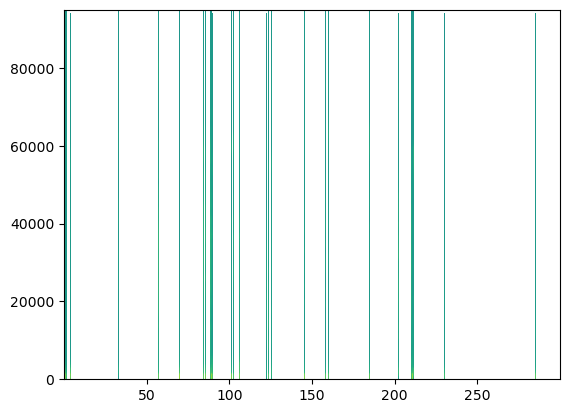

In [25]:
import matplotlib.pyplot as plt

# import reduced noise recording    
audiopath = r'C:\Users\gijst\Documents\Master Data Science\Thesis\methodology\example_rat_recording_reduced.flac'

data_red, samplerate_red = sf.read(audiopath)

powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(data_red, Fs=samplerate)
plt.show()

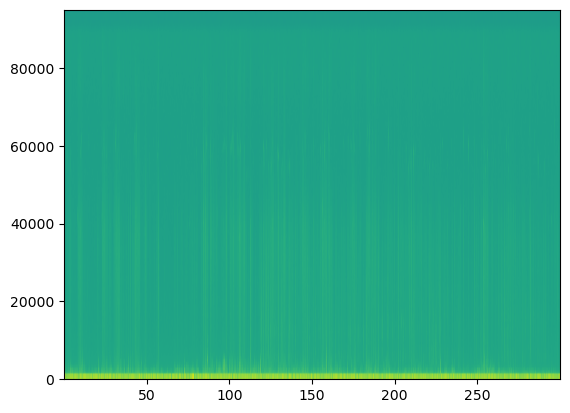

In [26]:
powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(data, Fs=samplerate)
plt.show()

In [56]:
block = sf.blocks(r'C:\Users\gijst\Documents\Master Data Science\Thesis\flevopark_1_audio1_2021-09-28_16-00-00_(0).flac', blocksize=10000000)
    

In [69]:
# loop trough the blocks and apply noise reduction and append all blocks together
reduced_noise_all = np.array([])
for bl in block:
    reduced_noise = nr.reduce_noise(y=bl, sr=samplerate, n_jobs=-1)
    np.concatenate((reduced_noise_all, reduced_noise), axis=None)
    

In [61]:
sf.write('test.flac', next(block), samplerate)

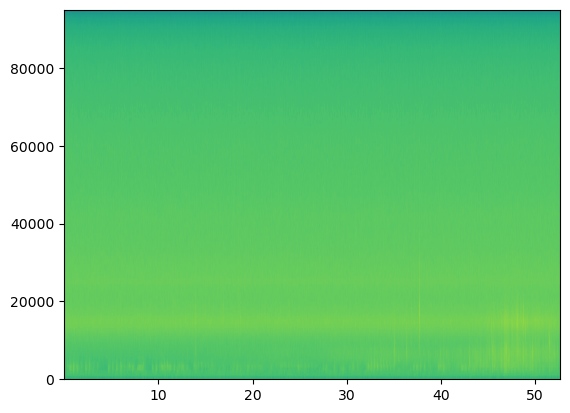

In [63]:
# load in test.flac
audiopath = r'C:\Users\gijst\Documents\Master Data Science\Thesis\methodology\test.flac'
data, samplerate = sf.read(audiopath)


powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(data, Fs=samplerate)
plt.show()



In [64]:
reduced_noise = nr.reduce_noise(y=data, sr=samplerate)

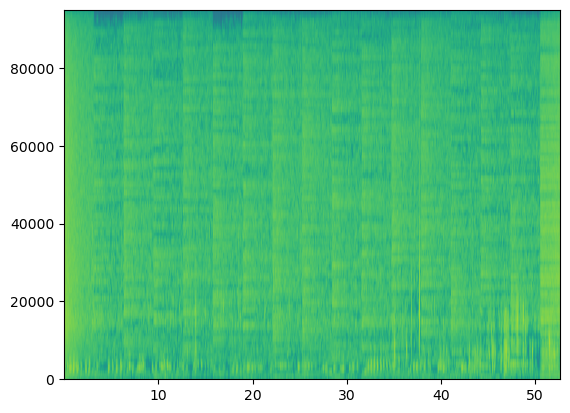

In [65]:
powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(reduced_noise, Fs=samplerate)
plt.show()

In [66]:
sf.write('flevo_reduced.flac', reduced_noise, samplerate)

In [67]:
reduced_noise

memmap([-4.35417316e-04,  2.54445185e-04,  3.17874215e-05, ...,
        -1.36722793e-04,  1.54759298e-05,  4.46360562e-05])